In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import random
import importlib
import mpt_functions as mpt
importlib.reload(mpt)

<module 'mpt_functions' from 'd:\\Code\\Graduation-Project\\mpt_functions.py'>

In [10]:
path = "C:/Users/bilge/Downloads/MetroPT3(AirCompressor).csv"
df = mpt.get_the_data_and_convert_datetime(path)
df = mpt.drop_a_column(df, "Unnamed: 0")
df.head()

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [11]:
df_day1 = mpt.filter_a_day("2020-03-01", df)  
df_minute = mpt.aggregate_as_a_minute(df_day1)

# Ensure timestamp is datetime and set as index
df_minute['timestamp'] = pd.to_datetime(df_minute['timestamp'])
df_minute = df_minute.set_index('timestamp')

# Select Oil_temperature and resample per second
df_pressure = df_minute[['Oil_temperature']]

# Downsample to 1-minute intervals
df_resampled = df_pressure.resample('1T').mean().dropna()

In [12]:
df_resampled.head()

,Oil_temperature
timestamp,
2020-03-01 04:00:00,66.800000
2020-03-01 04:01:00,66.475000
2020-03-01 04:02:00,65.554167
2020-03-01 04:03:00,63.195833
2020-03-01 04:04:00,61.608333


In [6]:
# Augmented Dickey-Fuller test for stationarity
adf_test = adfuller(df_resampled)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] > 0.05:
    print("Data is non-stationary. Differencing needed.")
    df_resampled = df_resampled.diff().dropna()

ADF Statistic: -1.5502560577532358
p-value: 0.5085202894210191
Data is non-stationary. Differencing needed.


In [7]:
df_resampled.head()

,Oil_temperature
timestamp,
2020-03-01 04:01:00,-0.325000
2020-03-01 04:02:00,-0.920833
2020-03-01 04:03:00,-2.358333
2020-03-01 04:04:00,-1.587500
2020-03-01 04:05:00,-0.941667


In [8]:
print(df_resampled.columns)

Index(['Oil_temperature'], dtype='object')


In [9]:
df_resampled.shape

(1199, 1)

In [9]:
df_resampled.index = pd.to_datetime(df_resampled.index)

# Drop any rows with NaN values
df_resampled = df_resampled.dropna()

# Define the hour range for forecasting
forecast_hour_start = pd.Timestamp("2020-03-01 00:00:00")  # Start of the hour
forecast_hour_end = pd.Timestamp("2020-03-01 12:00:00")    # End of the hour

# Slice the data for the specified hour
df_hour = df_resampled[(df_resampled.index >= forecast_hour_start) & (df_resampled.index < forecast_hour_end)]

# Print the shape and head of the resulting DataFrame
print("Hourly Data Shape:", df_hour.shape)
print(df_hour.head(12))

Hourly Data Shape: (64, 1)
                     Oil_temperature
timestamp                           
2020-03-01 04:00:00           66.950
2020-03-01 04:04:00           62.150
2020-03-01 04:05:00           60.675
2020-03-01 04:09:00           58.200
2020-03-01 04:13:00           57.850
2020-03-01 04:15:00           70.650
2020-03-01 04:43:00           62.650
2020-03-01 04:46:00           59.900
2020-03-01 04:47:00           59.100
2020-03-01 05:11:00           57.600
2020-03-01 05:21:00           66.300
2020-03-01 05:24:00           61.300


In [10]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model (example)
model = ARIMA(df_hour['Oil_temperature'], order=(2, 1, 2))  # Replace with your target column
model_fit = model.fit()

# Forecast the next 10 minutes
forecast = model_fit.forecast(steps=10)
print("Forecast for the next 10 minutes:", forecast)

d:\Anaconda\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Forecast for the next 10 minutes: 64    61.119843
65    67.208881
66    62.552930
67    63.869906
68    64.390778
69    63.634931
70    63.991137
71    63.978697
72    63.878692
73    63.950597
Name: predicted_mean, dtype: float64


d:\Anaconda\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [11]:
from pmdarima import auto_arima
auto_arima(df_hour['Oil_temperature']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   64
Model:                        SARIMAX   Log Likelihood                -187.807
Date:                Fri, 21 Mar 2025   AIC                            379.615
Time:                        11:19:40   BIC                            383.932
Sample:                             0   HQIC                           381.316
                                 - 64                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     63.6795      0.625    101.828      0.000      62.454      64.905
sigma2        20.7201      6.249      3.316      0.001       8.472      32.968
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 5.17
Prob(Q):                              0.76   Prob(JB):                         0.08
Heteroskedasticity (H):               1.35   Skew:                             0.38
Prob(H) (two-sided):                  0.49   Kurtosis:                         1.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

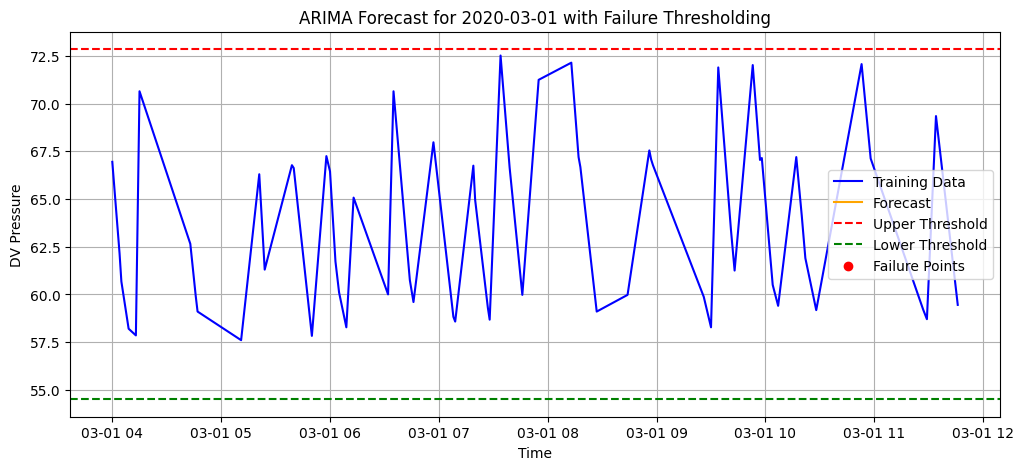

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate thresholds for Oil_temperature
upper_threshold = df_hour['Oil_temperature'].mean() + 2 * df_hour['Oil_temperature'].std()
lower_threshold = df_hour['Oil_temperature'].mean() - 2 * df_hour['Oil_temperature'].std()

forecast_index = pd.date_range(start=df_hour.index[-1] + pd.Timedelta(minutes=1),
                               periods=len(forecast), freq='T')
forecast = pd.Series(forecast, index=forecast_index)

# Identify failure points
failure_points = forecast[(forecast > upper_threshold) | (forecast < lower_threshold)]

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(df_hour.index, df_hour['Oil_temperature'], label='Training Data', color='blue')
plt.plot(forecast.index, forecast, label='Forecast', color='orange')
plt.axhline(upper_threshold, color='red', linestyle='dashed', label='Upper Threshold')
plt.axhline(lower_threshold, color='green', linestyle='dashed', label='Lower Threshold')
plt.scatter(failure_points.index, failure_points, color='red', label='Failure Points', zorder=3)
plt.legend()
plt.title("ARIMA Forecast for 2020-03-01 with Failure Thresholding")
plt.xlabel("Time")
plt.ylabel("DV Pressure")
plt.grid(True)
plt.show()